# World Values Analysis

## 1. Define question <br>

This project focuses on understanding the differences between attitudes to work around the world, and what drives those differences. Specifically:  <br> <br>
a) How do attitudes towards work differ around the globe? <br>
b) Are attitudes to work correlated to GDP and development efforts? <br>
c) If so, does increasing GDP lead or lag changing attitudes to work?

## 2. Get data

### Import necessary modules

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data_dictionary import *
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

pd.set_option('display.max_columns', 500)

### Import data

In [2]:
df = pd.read_stata('./world-values-survey-data/WVS_Longitudinal_1981_2014_stata_v2015_04_18.dta', convert_categoricals=False) # index_col='S025', 

### Clean data

#### Check shape and nulls; inspect header

In [3]:
df.shape

(341271, 1410)

In [4]:
df.head()

,S001,S002,S002EVS,S003,S003A,S004,S006,S007,S007_01,S008,S009,S009A,S010,S010_01,S010_02,S010_03,S010_04,S011,S012,S013,S013B,S014,S015,S016,S017,S017A,S018,S018A,S019,S019A,S020,S021,S021A,S022,S023,S024,S024A,S025,S025A,S026,S027,S028,A001,A001_CO,A002,A002_CO,A003,A003_CO,A004,A004_CO,A005,A005_CO,A006,A006_CO,A007,A008,A009,A010,A011,A012,A013,A014,A015,A016,A017,A018,A019,A020,A021,A022,A023,A024,A025,A026,A026_01,A027,A028,A029,A030,A031,A032,A033,A034,A035,A036,A037,A038,A039,A040,A041,A042,A043,A043_01,A043_01F,A043_F,A043B,A044,A045,A046,A047,A048,A049,A050,A050_01,A050_02,A050_03,A050_04,A051,A052,A053,A054,A055,A056,A057,A058,A059,A060,A061,A062,A063,A064,A065,A066,A067,A068,A069,A070,A071,A071B,A071C,A072,A073,A074,A075,A076,A077,A078,A079,A080,A080_F,A081,A082,A083,A084,A085,A086,A087,A088,A088B,A088C,A089,A090,A091,A092,A093,A094,A095,A096,A097,A097_F,A098,A099,A100,A101,A102,A103,A104,A105,A106,A106B,A106C,A107,A108,A109,A110,A111,A112,A113,A114,A115,A116,A117,A118,A119,A120,A121,A122,A123,A124_01,A124_02,A124_03,A124_04,A124_05,A124_06,A124_07,A124_08,A124_09,A124_10,A124_11,A124_12,A124_13,A124_14,A124_15,A124_16,A124_17,A124_18,A124_19,A124_20,A124_21,A124_22,A124_23,A124_24,A124_25,A124_26,A124_27,A124_28,A124_29,A124_30,A124_31,A124_32,A124_33,A124_34,A124_35,A124_36,A124_37,A124_38,A124_39,A124_40,A124_41,A124_42,A124_43,A124_44,A124_45,A124_46,A124_47,A124_48,A124_49,A124_50,A124_51,A124_52,A124_53,A124_54,A124_55,A124_56,A124_57,A124_58,A124_59,A124_60,A124_61,A165,...,G032,G033,G034,G035,G036,G037,G038,G039,G040,G041,G042,G043,G044,G045,G046,G047,G048,G049,G050,G051,H001,H002_01,H002_02,H002_03,H002_04,H002_05,H003_01,H003_02,H003_03,H004,H005,H006_01,H006_02,H006_03,H006_04,H006_05,H006_06,H007,H008_01,H008_02,H008_03,H008_04,I001,I002,U001A,U001B,U002A,U002B,U003A,U003B,U004A,U004B,U005A,U005B,U006A,U006B,V001,V001A,V002,V002A,V003,V004A,V004B,V004C,V004D,V004E,V004R,V005,V006,V006_2,V006_3,V006_4,V007A,V007B,V007C,V007D,V008,V009,V010,V011,V012,V013,V014,V015,V016,V017,V018,W001,W001A,W002A,W002B,W002C,W002D,W002E,W002R,W003,W004,W005,W005_2,W005_3,W005_4,W006A,W006B,W006C,W006D,W007,W008,W009,W010,W011,X001,X002,X002_01,X002_01A,X002_02,X002_02A,X002_03,X003,X003R,X003R2,X004,X005,X006,X006_01,X006_02,X007,X007_01,X007_02,X008,X009,X009_01,X010,X011,X011_01,X011_02,X011A,X012,X013,X014,X015,X016,X017,X018,X019,X020,X021,X022,X022_01,X022_02A,X022_02B,X022_03A,X022_03B,X022_04A,X022_04B,X022_05A,X022_05B,X022_06A,X022_06B,X023,X023R,X024,X024B,X025,X025A,X025B,X025C,X025CS,X025CSWVS,X025LIT,X025R,X026,X027,X028,X028_01,X029,X030,X031,X032,X032R,X032R_01,X033,X033R,X034,X034R,X034R_01,X035_2,X035_3,X035_4,X036,X036A,X036B,X036C,X036D,X037,X037_01,X037_02,X038,X039,X040,X041,X042_2,X042_3,X042_4,X043,X044,X045,X045B,X046,X047,X047A,X047A_01,X047B,X047B_01,X047C,X047C_01,X047CS,X047D,X047R,X048,X048A,X048B,X048C,X048D,X048E,X048F,X048G,X048WVS,X049,X049CS,X050,X051,X052,X053,X054,X055,Y001,Y002,Y003,Y010,Y011,Y012,Y013,Y014,Y020,Y021,Y022,Y023,Y024,TRADRAT5,survself
0,2,1,-4,392,392,-4.0,1.0,1,3.920120e+09,-4,JP,JP,-4.0,-4,-4,-4,-4,-4.0,-4,-4,-4,-4,-4,-4,1.089722,1.089722,0.905084,0.905084,1.357627,1.357627,1981,3.920121e+10,3.920121e+10,-4,-4,3921,3921,3921981,3921981,20150418,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,2,-2,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,1,-2,-4,1,-4,1,0,-4,1,-4,0,0,-4,-4,1,0,0,0,0,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,2,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,0,-4,0,0,0,0,0,0,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,0,0,0,0,-4,0,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,0,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,2,...,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,

#### We can relabel the columns using the data dictionary found at  http://www.worldvaluessurvey.org/WVSDocumentationWVL.jsp

In [5]:
new_column_labels = []

for i in df.columns:
    new_column_labels.append(column_map_dictionary.get(i, i))

In [6]:
new_column_labels2 = []

for i in new_column_labels:
    new_column_labels2.append(column_map_dictionary.get(i.lower(), i))

In [7]:
df.columns = new_column_labels2

In [8]:
df.head()

,Study,Wave,EVS-wave,Country/region,Country/regions [with split ups],Set,Original respondent number,Unified respondent number,Unified respondent number (EVS/WVS LF),Interviewer number,S009,S009A,Total length of interview,Time of interview: start hour,Time of interview: start minute,Time of interview: end hour,Time of interview: end minute,Time at the end of interview,Date interview,Respondent interested during the interview,Interview privacy,Confidence respondent during the interview,On the whole respondent looked,Language in which interview was conducted,Weight,Weight [with split ups],Equilibrated weight-1000,Equilibrated weight-1000 [with split ups],Equilibrated weight-1500,Equilibrated weight-1500 [with split ups],Year survey,Country - wave - study - set - year,Country2 - wave - study - set - year,Year/month of start-fieldwork,Year/month of end-fieldwork,Country - wave,Country - wave [with split ups],Country - year,Country - year [with split ups],File version (yyyymmdd),split ballot,split oecd,Important in life: Family,Family important,Important in life: Friends,Friends important,Important in life: Leisure time,Leisure time,Important in life: Politics,Politics important,Important in life: Work,Work important,Important in life: Religion,Religion important,Service to others important in life,Feeling of happiness,State of health (subjective),Ever felt very excited or interested,Ever felt restless,Ever felt proud because someone complimented you,Ever felt very lonely or remote from other people,Ever felt pleased about having accomplished something,Ever felt bored,Ever felt on top of the world,Ever felt depressed or very unhappy,Ever felt that things were going your way,Ever felt upset because somebody criticized you,"When you are home, do you feel relaxed","When you are home, do you feel anxious","When you are home, do you feel happy","When you are home, do you feel aggressive","When you are home, do you feel secure",Respect and love for parents,Parents responsibilities to their children,Children responsibilities to their parents in need at expense of/not sacrifice own well-being,Important child qualities: good manners,Important child qualities: politeness and neatness,Important child qualities: independence,Important child qualities: hard work,Important child qualities: honesty,Important child qualities: feeling of responsibility,Important child qualities: patience,Important child qualities: imagination,Important child qualities: tolerance and respect for other people,Important child qualities: leadership,Important child qualities: self-control,Important child qualities: thrift saving money and things,Important child qualities: determination perseverance,Important child qualities: religious faith,Important child qualities: unselfishness,Important child qualities: obedience,Important child qualities: loyalty,Important child qualities: none,Flag variable: learn children at home: none,Flag variable: learn children at home,Important child qualities: Self-expression,What children should learn 1,What children should learn 2,Abortion when the mothers health is at risk,Abortion when child physically handicapped,Abortion when woman not married,Abortion if not wanting more children,Way of spending leisure time,Leisure time: meeting nice people,Leisure time: relaxing,Leisure time: doing as I want,Leisure time: learning something new,Spend leisure time: alone,Spend leisure time: with family,Spend leisure time: with friends,Spend leisure time: in a lively place,Spend leisure time: all equally,Spend leisure time with: don’t know,Spend time with parents or other relatives,Spend time with friends,Spend time with colleagues from work,"Spend time with people at your church, mosque or synagogue","Spend time with people at sport, culture, communal organization",How often discusses political matters with friends,"Persuading friends, relatives or fellow workers",Member: Belong to social welfare service for elderly,Member: Belong to religious organi

#### Note that the country is listed as a code (in 'Country/region' column). We want to add the name of the country

In [9]:
# Turn each country/ code combination into an item in a list, by splitting on new lines
country_list = country_list.split('\n')

# Create a list of country codes and country names
country_code_list = []
country_name_list = []
for country_pair in country_list:
    country_code_list.append(country_pair.split(':')[0])
    country_name_list.append(country_pair.split(':')[1])
    
# Turn the country code / name lookup into a dataframe, to allow a merge with the original dataframe
country_dictionary = {'country_code': country_code_list, 'country_name': country_name_list}
country_lookup = pd.DataFrame(country_dictionary)

In [10]:
# Merge country names into original dataframe
df['Country/region'] = df['Country/region'].astype(int) # match dtypes
country_lookup['country_code'] = country_lookup['country_code'].astype(int)
df = pd.merge(df, country_lookup, left_on='Country/region', right_on='country_code', how = 'left')
df.head()

,Study,Wave,EVS-wave,Country/region,Country/regions [with split ups],Set,Original respondent number,Unified respondent number,Unified respondent number (EVS/WVS LF),Interviewer number,S009,S009A,Total length of interview,Time of interview: start hour,Time of interview: start minute,Time of interview: end hour,Time of interview: end minute,Time at the end of interview,Date interview,Respondent interested during the interview,Interview privacy,Confidence respondent during the interview,On the whole respondent looked,Language in which interview was conducted,Weight,Weight [with split ups],Equilibrated weight-1000,Equilibrated weight-1000 [with split ups],Equilibrated weight-1500,Equilibrated weight-1500 [with split ups],Year survey,Country - wave - study - set - year,Country2 - wave - study - set - year,Year/month of start-fieldwork,Year/month of end-fieldwork,Country - wave,Country - wave [with split ups],Country - year,Country - year [with split ups],File version (yyyymmdd),split ballot,split oecd,Important in life: Family,Family important,Important in life: Friends,Friends important,Important in life: Leisure time,Leisure time,Important in life: Politics,Politics important,Important in life: Work,Work important,Important in life: Religion,Religion important,Service to others important in life,Feeling of happiness,State of health (subjective),Ever felt very excited or interested,Ever felt restless,Ever felt proud because someone complimented you,Ever felt very lonely or remote from other people,Ever felt pleased about having accomplished something,Ever felt bored,Ever felt on top of the world,Ever felt depressed or very unhappy,Ever felt that things were going your way,Ever felt upset because somebody criticized you,"When you are home, do you feel relaxed","When you are home, do you feel anxious","When you are home, do you feel happy","When you are home, do you feel aggressive","When you are home, do you feel secure",Respect and love for parents,Parents responsibilities to their children,Children responsibilities to their parents in need at expense of/not sacrifice own well-being,Important child qualities: good manners,Important child qualities: politeness and neatness,Important child qualities: independence,Important child qualities: hard work,Important child qualities: honesty,Important child qualities: feeling of responsibility,Important child qualities: patience,Important child qualities: imagination,Important child qualities: tolerance and respect for other people,Important child qualities: leadership,Important child qualities: self-control,Important child qualities: thrift saving money and things,Important child qualities: determination perseverance,Important child qualities: religious faith,Important child qualities: unselfishness,Important child qualities: obedience,Important child qualities: loyalty,Important child qualities: none,Flag variable: learn children at home: none,Flag variable: learn children at home,Important child qualities: Self-expression,What children should learn 1,What children should learn 2,Abortion when the mothers health is at risk,Abortion when child physically handicapped,Abortion when woman not married,Abortion if not wanting more children,Way of spending leisure time,Leisure time: meeting nice people,Leisure time: relaxing,Leisure time: doing as I want,Leisure time: learning something new,Spend leisure time: alone,Spend leisure time: with family,Spend leisure time: with friends,Spend leisure time: in a lively place,Spend leisure time: all equally,Spend leisure time with: don’t know,Spend time with parents or other relatives,Spend time with friends,Spend time with colleagues from work,"Spend time with people at your church, mosque or synagogue","Spend time with people at sport, culture, communal organization",How often discusses political matters with friends,"Persuading friends, relatives or fellow workers",Member: Belong to social welfare service for elderly,Member: Belong to religious organi

In [11]:
df['country_year'] = df['country_name'].astype(str) + '_' + df['Year survey'].astype(str)

#### Now, zoom in on the columns of interest:  What is important in a job?

In [12]:
job_qs = important_in_a_job
baseline_qs = ['Wave', 'Year survey', 'Country/region', 'country_name', 'country_year']
job_df = df[baseline_qs + job_qs]

In [13]:
job_df.head()

,Wave,Year survey,Country/region,country_name,country_year,Important in a job: good pay,Important in a job: not too much pressure,Important in a job: good job security,Important in a job: a respected job,Important in a job: good hours,Important in a job: an opportunity to use initiative,Important in a job: generous holidays,Important in a job: that you can achieve something,Important in a job: a responsible job,Important in a job: a job that is interesting,Important in a job: a job that meets one´s abilities,Important in a job: pleasant people to work with,Important in a job: good chances for promotion,Important in a job: a useful job for society,Important in a job: meeting people,Important in a job: good physical working conditions,Important in a job: to have time off at the weekends,Important in a job: learning new skills,Important in a job: family friendly,Important in a job: have a say,Important in a job: people treated equally,Important in a job: none of these
0,1,1981,392,Japan,Japan_1981,0,0,1,1,0,0,0,0,1,0,1,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
1,1,1981,392,Japan,Japan_1981,1,0,0,1,0,1,0,1,1,1,1,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
2,1,1981,392,Japan,Japan_1981,0,0,0,0,0,0,0,0,0,0,1,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
3,1,1981,392,Japan,Japan_1981,0,0,0,0,0,0,0,0,0,0,1,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4
4,1,1981,392,Japan,Japan_1981,0,0,1,0,1,1,0,0,0,0,0,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4,-4


In [14]:
# Count nulls
job_df.isnull().sum().sum()

3780

In [15]:
# Count values greater than or equal to zero (from the data dictionary, negative numbers indicate missing data)
(job_df[job_qs] >= 0).sum()

Important in a job: good pay                            151669
Important in a job: not too much pressure               151669
Important in a job: good job security                   151669
Important in a job: a respected job                     151669
Important in a job: good hours                          148933
Important in a job: an opportunity to use initiative    149647
Important in a job: generous holidays                   150699
Important in a job: that you can achieve something      148933
Important in a job: a responsible job                   151669
Important in a job: a job that is interesting           148933
Important in a job: a job that meets one´s abilities    150516
Important in a job: pleasant people to work with         20175
Important in a job: good chances for promotion           20175
Important in a job: a useful job for society             20175
Important in a job: meeting people                       17439
Important in a job: good physical working conditions   

In [16]:
# Focusing in on the columns with the fewest missing data points:
refined_job_qs = ['Important in a job: good pay',
 'Important in a job: not too much pressure',
 'Important in a job: good job security',
 'Important in a job: a respected job',
 'Important in a job: good hours',
 'Important in a job: an opportunity to use initiative',
 'Important in a job: generous holidays',
 'Important in a job: that you can achieve something',
 'Important in a job: a responsible job',
 'Important in a job: a job that is interesting',
 'Important in a job: a job that meets one´s abilities']

refined_job_df = df[baseline_qs + refined_job_qs].copy()

(refined_job_df[refined_job_qs] >= 0).sum()

Important in a job: good pay                            151669
Important in a job: not too much pressure               151669
Important in a job: good job security                   151669
Important in a job: a respected job                     151669
Important in a job: good hours                          148933
Important in a job: an opportunity to use initiative    149647
Important in a job: generous holidays                   150699
Important in a job: that you can achieve something      148933
Important in a job: a responsible job                   151669
Important in a job: a job that is interesting           148933
Important in a job: a job that meets one´s abilities    150516
dtype: int64

In [17]:
# Check how many people partially answered the questions
refined_job_df['number_of_jobs_qs_answered'] = (refined_job_df[refined_job_qs] >= 0).sum(axis = 1)

In [18]:
refined_job_df['number_of_jobs_qs_answered'].value_counts()

0     189602
11    144788
10      4145
8       2736
Name: number_of_jobs_qs_answered, dtype: int64

In [19]:
# Overall, most people answered all the questions (144k) or none (189k). 
# A small proportion (~6k) responsed to some but not all of the questions
# Dropping respondants who did not answer all questiosn will improve consistency and reduce bias, for a relatively small data loss
# Consequently, we will focus only on those respondants who answered all questions
mask = refined_job_df['number_of_jobs_qs_answered'] == 11
refined_job_df = refined_job_df[mask]

## 3. EDA

### Preview the data and look for correlations (clustering of input variables / multicolinearity)

In [20]:
# View dataframe
refined_job_df.head()

,Wave,Year survey,Country/region,country_name,country_year,Important in a job: good pay,Important in a job: not too much pressure,Important in a job: good job security,Important in a job: a respected job,Important in a job: good hours,Important in a job: an opportunity to use initiative,Important in a job: generous holidays,Important in a job: that you can achieve something,Important in a job: a responsible job,Important in a job: a job that is interesting,Important in a job: a job that meets one´s abilities,number_of_jobs_qs_answered
0,1,1981,392,Japan,Japan_1981,0,0,1,1,0,0,0,0,1,0,1,11
1,1,1981,392,Japan,Japan_1981,1,0,0,1,0,1,0,1,1,1,1,11
2,1,1981,392,Japan,Japan_1981,0,0,0,0,0,0,0,0,0,0,1,11
3,1,1981,392,Japan,Japan_1981,0,0,0,0,0,0,0,0,0,0,1,11
4,1,1981,392,Japan,Japan_1981,0,0,1,0,1,1,0,0,0,0,0,11


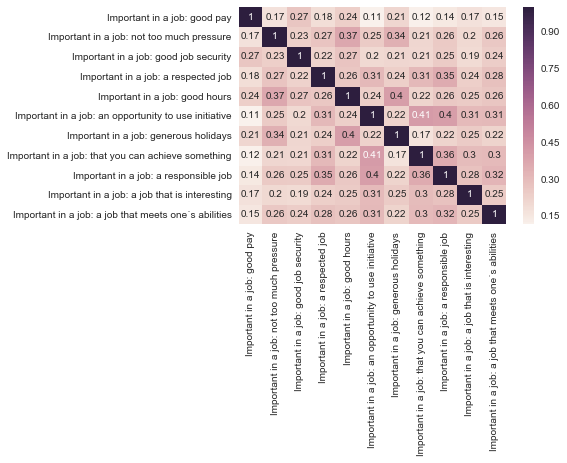

In [21]:
# Look at correlation matrix between different questions
sns.heatmap(refined_job_df[refined_job_qs].corr(), annot = True);

#### Though correlations are all < 0.5, we can see correlated clusters of variables:
- Achieving something, responsible job and opportunity to use initiative (correlations of ~0.4)
- Good hours, generous holidays, not too much pressure (correlations of ~0.35)

### Understand sample size

In [22]:
# View dataframe
refined_job_df.head()

,Wave,Year survey,Country/region,country_name,country_year,Important in a job: good pay,Important in a job: not too much pressure,Important in a job: good job security,Important in a job: a respected job,Important in a job: good hours,Important in a job: an opportunity to use initiative,Important in a job: generous holidays,Important in a job: that you can achieve something,Important in a job: a responsible job,Important in a job: a job that is interesting,Important in a job: a job that meets one´s abilities,number_of_jobs_qs_answered
0,1,1981,392,Japan,Japan_1981,0,0,1,1,0,0,0,0,1,0,1,11
1,1,1981,392,Japan,Japan_1981,1,0,0,1,0,1,0,1,1,1,1,11
2,1,1981,392,Japan,Japan_1981,0,0,0,0,0,0,0,0,0,0,1,11
3,1,1981,392,Japan,Japan_1981,0,0,0,0,0,0,0,0,0,0,1,11
4,1,1981,392,Japan,Japan_1981,0,0,1,0,1,1,0,0,0,0,0,11


In [23]:
# Summary statistics
country_counts = refined_job_df.groupby('country_year').count()
country_counts[refined_job_qs].describe()

,Important in a job: good pay,Important in a job: not too much pressure,Important in a job: good job security,Important in a job: a respected job,Important in a job: good hours,Important in a job: an opportunity to use initiative,Important in a job: generous holidays,Important in a job: that you can achieve something,Important in a job: a responsible job,Important in a job: a job that is interesting,Important in a job: a job that meets one´s abilities
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,1392.192308,1392.192308,1392.192308,1392.192308,1392.192308,1392.192308,1392.192308,1392.192308,1392.192308,1392.192308,1392.192308
std,556.828137,556.828137,556.828137,556.828137,556.828137,556.828137,556.828137,556.828137,556.828137,556.828137,556.828137
min,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000,417.000000
25%,1007.750000,1007.750000,1007.750000,1007.750000,1007.750000,1007.750000,1007.750000,1007.750000,1007.750000,1007.750000,1007.750000
50%,1200.500000,1200.500000,1200.500000,1200.500000,1200.500000,1200.500000,1200.500000,1200.500000,1200.500000,1200.500000,1200.500000
75%,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000,1532.000000
max,3401.000000,3401.000000,3401.000000,3401.000000,3401.000000,3401.000000,3401.000000,3401.000000,3401.000000,3401.000000,3401.000000


In [24]:
# Summary
print(f'Each question was, on average, answered by {country_counts.iloc[:,0].mean():.0f} people in each wave, with a \
min of {country_counts.iloc[:,0].min():.0f} and a max of {country_counts.iloc[:,0].max():.0f}')

Each question was, on average, answered by 1392 people in each wave, with a min of 417 and a max of 3401


### See how responses evolve on a country-by-country level over time

In [25]:
# Aggregate
country_averages = refined_job_df.groupby('country_year').mean()
country_averages.head()

,Wave,Year survey,Country/region,Important in a job: good pay,Important in a job: not too much pressure,Important in a job: good job security,Important in a job: a respected job,Important in a job: good hours,Important in a job: an opportunity to use initiative,Important in a job: generous holidays,Important in a job: that you can achieve something,Important in a job: a responsible job,Important in a job: a job that is interesting,Important in a job: a job that meets one´s abilities,number_of_jobs_qs_answered
country_year,,,,,,,,,,,,,,,
Albania_1998,3.0,1998,8.0,0.994995,0.372372,0.853854,0.417417,0.610611,0.426426,0.533534,0.521522,0.173173,0.458458,0.888889,11.0
Albania_2002,4.0,2002,8.0,0.952000,0.455000,0.812000,0.645000,0.550000,0.397000,0.483000,0.513000,0.254000,0.411000,0.294000,11.0
Algeria_2002,4.0,2002,12.0,0.897816,0.595164,0.863495,0.719969,0.511700,0.435257,0.205148,0.602964,0.464119,0.565523,0.701248,11.0
Argentina_1984,1.0,1984,32.0,0.862687,0.366169,0.528358,0.264677,0.560199,0.468657,0.371144,0.338308,0.331343,0.383085,0.352239,11.0
Argentina_1991,2.0,1991,32.0,0.840319,0.407186,0.632735,0.428144,0.435130,0.546906,0.299401,0.501996,0.581836,0.506986,0.584830,11.0


In [26]:
# Add country name column
country_averages['country_name'] = [country_averages.index[i][0:country_averages.index[i].find('_')] for i in range(0, len(country_averages.index))]

In [27]:
# Assess data availability
country_averages['country_name'].value_counts()[0:10]

Mexico        5
Japan         4
Argentina     4
Turkey        3
Spain         3
China         3
India         3
Chile         3
nan           2
Czech Rep.    2
Name: country_name, dtype: int64

In [28]:
country_averages['country_name'].value_counts().count()

64

#### Of the 64 countries included in the datset, 8 have data from three or more waves; we will focus on these

In [29]:
# Create sub-dfs for each of these countries
longitudinal_countries = ['Mexico', 'Japan', 'Argentina', 'India', 'China', 'Chile', 'Turkey','Spain']

In [30]:
for index, df in country_averages.groupby(country_averages.index):
    if index == 'Mexico':
        display(df)

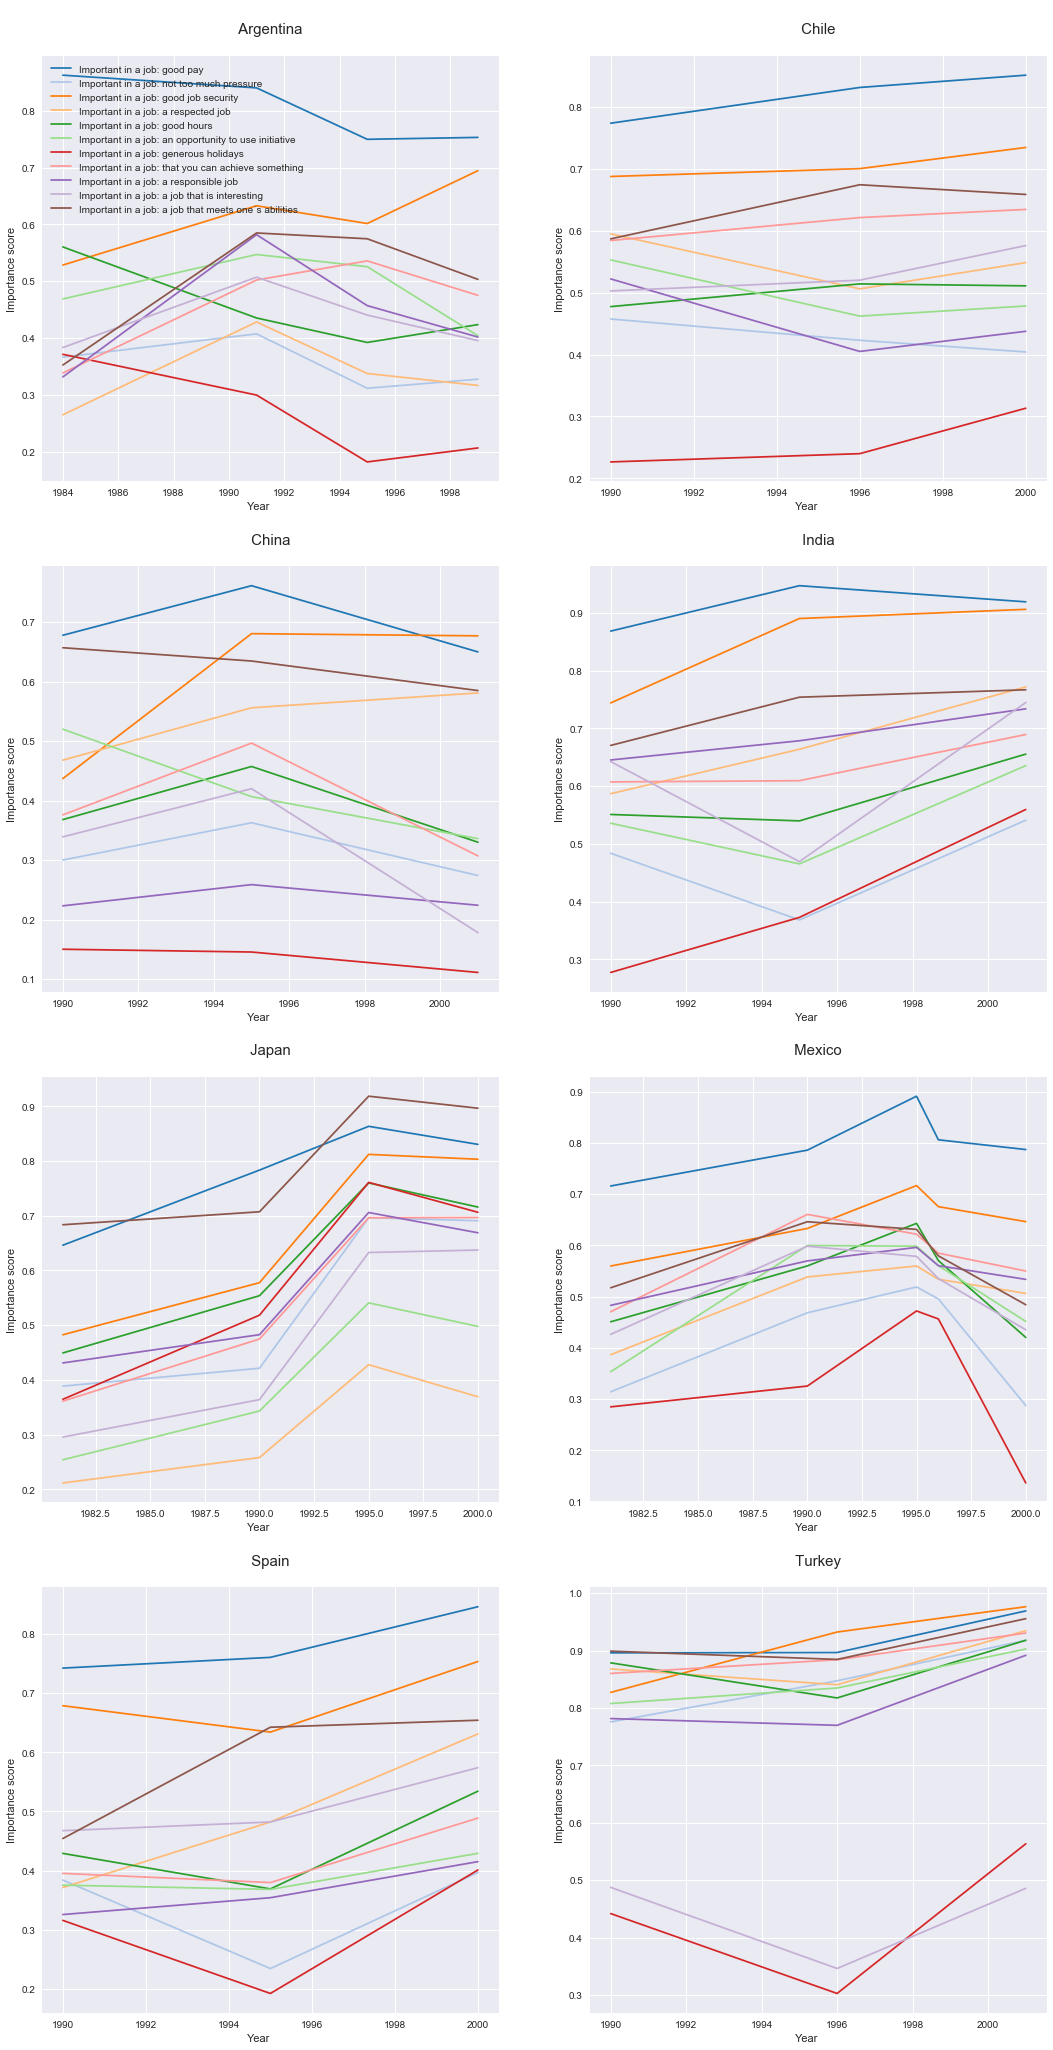

In [31]:
# Plot evolution of values over time

country_averages.index = country_averages['country_name']

n_cols = 2
n_rows = int(len(longitudinal_countries)//n_cols)
figure, ax = plt.subplots(nrows = n_rows, ncols=n_cols, figsize=(18,36))
i = 0 # this is a counter to tell matplotlib which axis to plot on
_cmap = plt.get_cmap('tab20')

for index, dataframe in country_averages.groupby(country_averages.index):
    if index in longitudinal_countries:
        ax[i//n_cols][i%n_cols].set_title(f"\n {index} \n", fontsize = 15)
        for j in range(0, len(refined_job_qs)): # this for loop is used to improve line colors on charts
            ax[i//n_cols][i%n_cols].plot(dataframe['Year survey'], dataframe[refined_job_qs[j]], c=_cmap.colors[j])
        ax[i//n_cols][i%n_cols].set_xlabel('Year', horizontalalignment = 'right')
        ax[i//n_cols][i%n_cols].set_ylabel('Importance score')
        if i == 0:
            ax[i//n_cols][i%n_cols].legend(refined_job_qs, )
        i +=1

#### Normalizing our data

In some countries (e.g., Japan, Mexico) the variables tend to trend up and down together. This could be an artefact of how the survey was administered: the value for each cell is the percent of respondants who mentioned something as important. In some years, the interviews may have been longer or more comprehensive than others. To account for this fact, we can look at the number of times an attribute was mentioned as a % of the total.

In [32]:
country_averages['total_mentions'] = country_averages[refined_job_qs].sum(axis = 1)
country_averages.head()

,Wave,Year survey,Country/region,Important in a job: good pay,Important in a job: not too much pressure,Important in a job: good job security,Important in a job: a respected job,Important in a job: good hours,Important in a job: an opportunity to use initiative,Important in a job: generous holidays,Important in a job: that you can achieve something,Important in a job: a responsible job,Important in a job: a job that is interesting,Important in a job: a job that meets one´s abilities,number_of_jobs_qs_answered,country_name,total_mentions
country_name,,,,,,,,,,,,,,,,,
Albania,3.0,1998,8.0,0.994995,0.372372,0.853854,0.417417,0.610611,0.426426,0.533534,0.521522,0.173173,0.458458,0.888889,11.0,Albania,6.251251
Albania,4.0,2002,8.0,0.952000,0.455000,0.812000,0.645000,0.550000,0.397000,0.483000,0.513000,0.254000,0.411000,0.294000,11.0,Albania,5.766000
Algeria,4.0,2002,12.0,0.897816,0.595164,0.863495,0.719969,0.511700,0.435257,0.205148,0.602964,0.464119,0.565523,0.701248,11.0,Algeria,6.562402
Argentina,1.0,1984,32.0,0.862687,0.366169,0.528358,0.264677,0.560199,0.468657,0.371144,0.338308,0.331343,0.383085,0.352239,11.0,Argentina,4.826866
Argentina,2.0,1991,32.0,0.840319,0.407186,0.632735,0.428144,0.435130,0.546906,0.299401,0.501996,0.581836,0.506986,0.584830,11.0,Argentina,5.765469


In [33]:
for column in refined_job_qs:
    country_averages[f'normalized {column}']=country_averages[column]/country_averages['total_mentions'] * 100 
    # * 100 to get pct

In [34]:
normalized_refined_job_qs = [f'normalized {column}'for column in refined_job_qs]
country_averages['normalized total_mentions'] = country_averages[normalized_refined_job_qs].sum(axis = 1)

In [35]:
country_averages.head()

,Wave,Year survey,Country/region,Important in a job: good pay,Important in a job: not too much pressure,Important in a job: good job security,Important in a job: a respected job,Important in a job: good hours,Important in a job: an opportunity to use initiative,Important in a job: generous holidays,Important in a job: that you can achieve something,Important in a job: a responsible job,Important in a job: a job that is interesting,Important in a job: a job that meets one´s abilities,number_of_jobs_qs_answered,country_name,total_mentions,normalized Important in a job: good pay,normalized Important in a job: not too much pressure,normalized Important in a job: good job security,normalized Important in a job: a respected job,normalized Important in a job: good hours,normalized Important in a job: an opportunity to use initiative,normalized Important in a job: generous holidays,normalized Important in a job: that you can achieve something,normalized Important in a job: a responsible job,normalized Important in a job: a job that is interesting,normalized Important in a job: a job that meets one´s abilities,normalized total_mentions
country_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albania,3.0,1998,8.0,0.994995,0.372372,0.853854,0.417417,0.610611,0.426426,0.533534,0.521522,0.173173,0.458458,0.888889,11.0,Albania,6.251251,15.916733,5.956765,13.658927,6.677342,9.767814,6.821457,8.534828,8.342674,2.770216,7.333867,14.219376,100.0
Albania,4.0,2002,8.0,0.952000,0.455000,0.812000,0.645000,0.550000,0.397000,0.483000,0.513000,0.254000,0.411000,0.294000,11.0,Albania,5.766000,16.510579,7.891086,14.082553,11.186264,9.538675,6.885189,8.376691,8.896982,4.405134,7.127992,5.098855,100.0
Algeria,4.0,2002,12.0,0.897816,0.595164,0.863495,0.719969,0.511700,0.435257,0.205148,0.602964,0.464119,0.565523,0.701248,11.0,Algeria,6.562402,13.681208,9.069298,13.158208,10.971116,7.797456,6.632592,3.126114,9.188161,7.072388,8.617616,10.685843,100.0
Argentina,1.0,1984,32.0,0.862687,0.366169,0.528358,0.264677,0.560199,0.468657,0.371144,0.338308,0.331343,0.383085,0.352239,11.0,Argentina,4.826866,17.872604,7.586065,10.946197,5.483405,11.605854,9.709338,7.689136,7.008864,6.864564,7.936508,7.297464,100.0
Argentina,2.0,1991,32.0,0.840319,0.407186,0.632735,0.428144,0.435130,0.546906,0.299401,0.501996,0.581836,0.506986,0.584830,11.0,Argentina,5.765469,14.575039,7.062489,10.974554,7.426000,7.547170,9.485892,5.193007,8.706941,10.091743,8.793491,10.143673,100.0


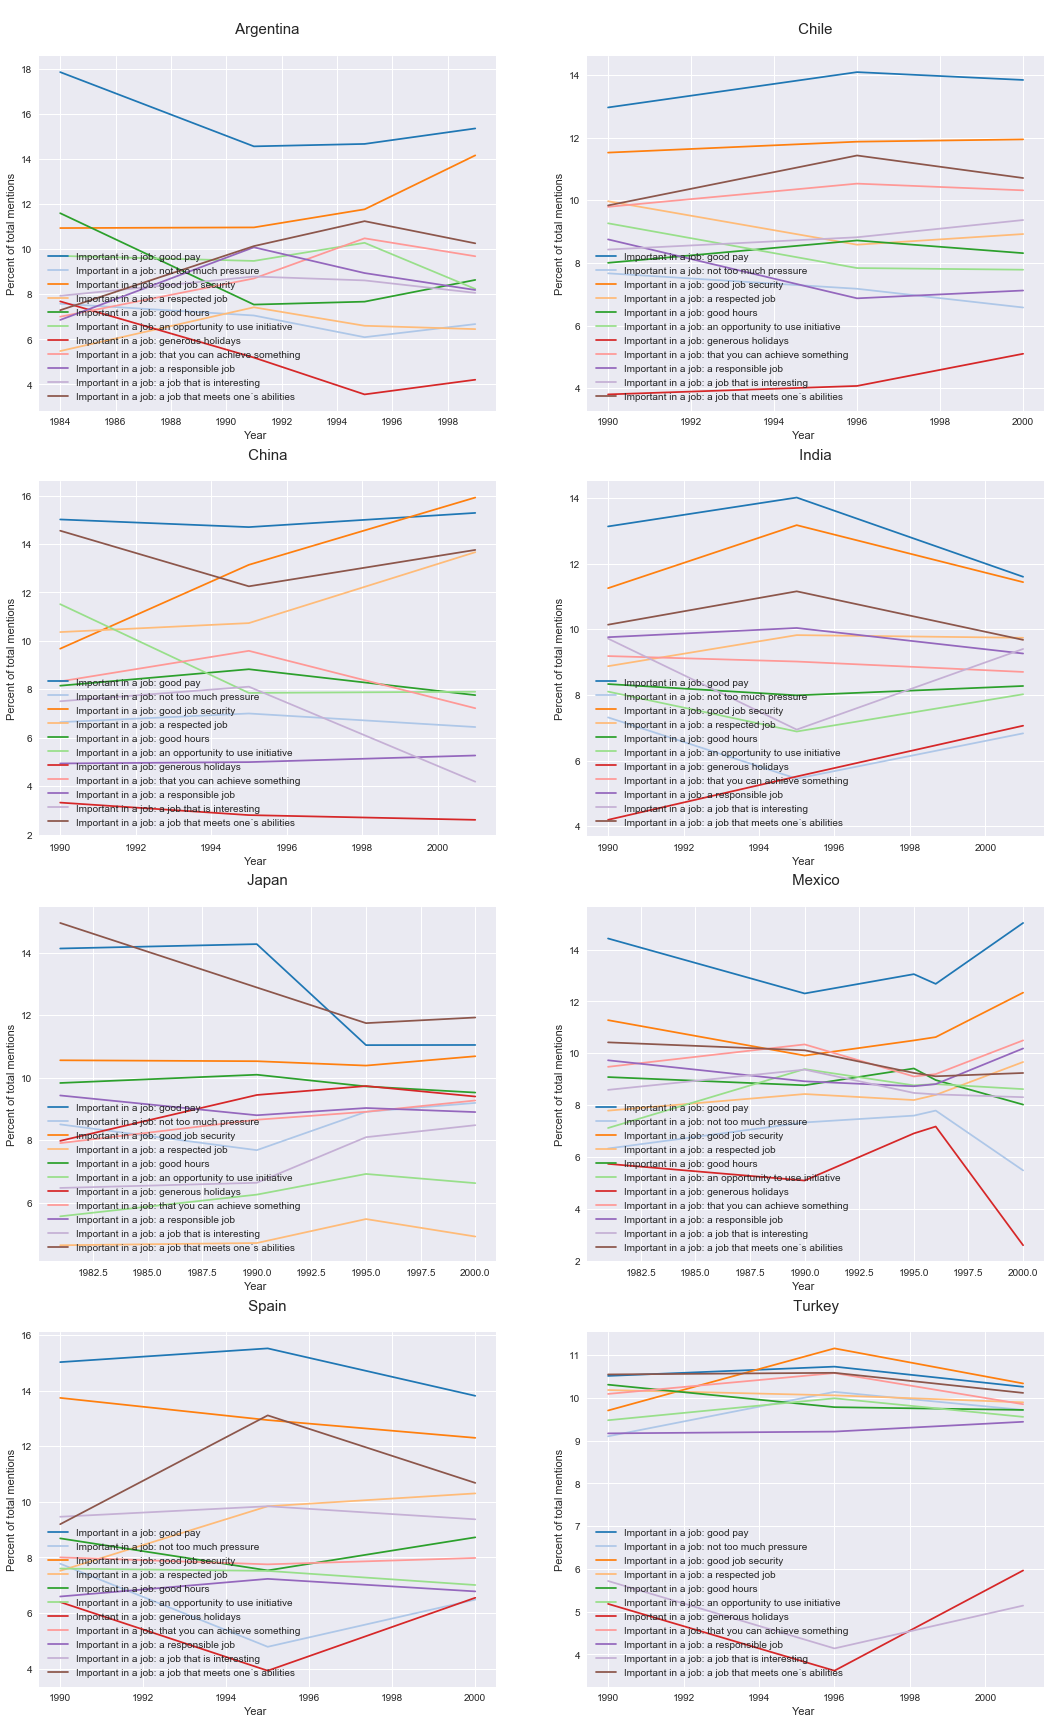

In [36]:
# Plot evolution of values over time

country_averages.index = country_averages['country_name']

n_cols = 2
n_rows = int(len(longitudinal_countries)//n_cols)
figure, ax = plt.subplots(nrows = n_rows, ncols=n_cols, figsize=(18,30))
i = 0 # this is a counter to tell matplotlib which axis to plot on
_cmap = plt.get_cmap('tab20')

for index, dataframe in country_averages.groupby(country_averages.index):
    if index in longitudinal_countries:
        ax[i//n_cols][i%n_cols].set_title(f"\n {index} \n", fontsize = 15)
        for j in range(0, len(normalized_refined_job_qs)): # this for loop is used to improve line colors on charts
            ax[i//n_cols][i%n_cols].plot(dataframe['Year survey'], dataframe[normalized_refined_job_qs[j]], c=_cmap.colors[j])
        ax[i//n_cols][i%n_cols].set_xlabel('Year', horizontalalignment = 'right')
        # ax[i//n_cols][i%n_cols].set_xlim(xmin = 1980)
        ax[i//n_cols][i%n_cols].set_ylabel('Percent of total mentions')
        ax[i//n_cols][i%n_cols].legend(refined_job_qs, loc = 'lower left')
        i +=1

#### Feature engineering for clustering analysis

As noted above, we can see that certain variables are correlated:
- Achieving something, responsible job and opportunity to use initiative (correlations of ~0.4)
- Good hours, generous holidays, not too much pressure (correlations of ~0.35)

Using a methodology similar to PCA, we can create new features to reduce the dimensionality of our features.

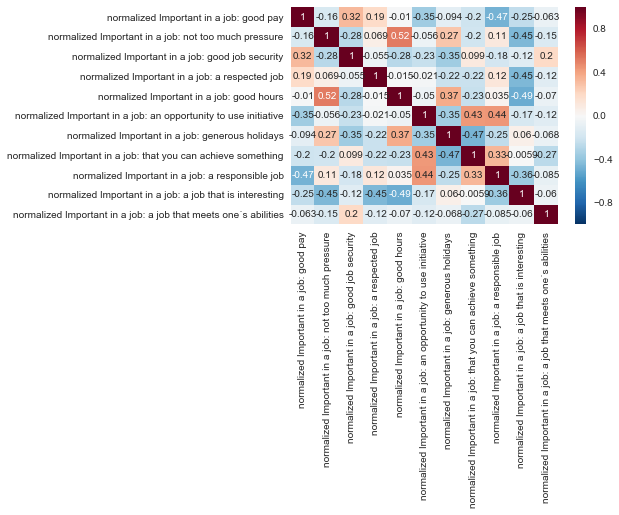

In [37]:
# Look at correlation matrix between different questions
sns.heatmap(country_averages[normalized_refined_job_qs].corr(), annot = True);

In [38]:
# Good hours, not too much pressure, holidays
# Responsible, initiative, achieve
# Security, pay

In [39]:
normalized_refined_job_qs

['normalized Important in a job: good pay',
 'normalized Important in a job: not too much pressure',
 'normalized Important in a job: good job security',
 'normalized Important in a job: a respected job',
 'normalized Important in a job: good hours',
 'normalized Important in a job: an opportunity to use initiative',
 'normalized Important in a job: generous holidays',
 'normalized Important in a job: that you can achieve something',
 'normalized Important in a job: a responsible job',
 'normalized Important in a job: a job that is interesting',
 'normalized Important in a job: a job that meets one´s abilities']

In [40]:
# Create new features

# Achieving_responsible_initiative

country_averages['normalized achieving_responsible_initiative'] = \
    country_averages['normalized Important in a job: that you can achieve something'] + \
    country_averages['normalized Important in a job: a responsible job'] + \
    country_averages['normalized Important in a job: an opportunity to use initiative']

# Hours_holidays_pressure

country_averages['normalized hours_holidays_pressure'] = \
    country_averages['normalized Important in a job: good hours'] + \
    country_averages['normalized Important in a job: generous holidays'] + \
    country_averages['normalized Important in a job: not too much pressure']

In [41]:
country_averages.head()

,Wave,Year survey,Country/region,Important in a job: good pay,Important in a job: not too much pressure,Important in a job: good job security,Important in a job: a respected job,Important in a job: good hours,Important in a job: an opportunity to use initiative,Important in a job: generous holidays,Important in a job: that you can achieve something,Important in a job: a responsible job,Important in a job: a job that is interesting,Important in a job: a job that meets one´s abilities,number_of_jobs_qs_answered,country_name,total_mentions,normalized Important in a job: good pay,normalized Important in a job: not too much pressure,normalized Important in a job: good job security,normalized Important in a job: a respected job,normalized Important in a job: good hours,normalized Important in a job: an opportunity to use initiative,normalized Important in a job: generous holidays,normalized Important in a job: that you can achieve something,normalized Important in a job: a responsible job,normalized Important in a job: a job that is interesting,normalized Important in a job: a job that meets one´s abilities,normalized total_mentions,normalized achieving_responsible_initiative,normalized hours_holidays_pressure
country_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Albania,3.0,1998,8.0,0.994995,0.372372,0.853854,0.417417,0.610611,0.426426,0.533534,0.521522,0.173173,0.458458,0.888889,11.0,Albania,6.251251,15.916733,5.956765,13.658927,6.677342,9.767814,6.821457,8.534828,8.342674,2.770216,7.333867,14.219376,100.0,17.934347,24.259408
Albania,4.0,2002,8.0,0.952000,0.455000,0.812000,0.645000,0.550000,0.397000,0.483000,0.513000,0.254000,0.411000,0.294000,11.0,Albania,5.766000,16.510579,7.891086,14.082553,11.186264,9.538675,6.885189,8.376691,8.896982,4.405134,7.127992,5.098855,100.0,20.187305,25.806452
Algeria,4.0,2002,12.0,0.897816,0.595164,0.863495,0.719969,0.511700,0.435257,0.205148,0.602964,0.464119,0.565523,0.701248,11.0,Algeria,6.562402,13.681208,9.069298,13.158208,10.971116,7.797456,6.632592,3.126114,9.188161,7.072388,8.617616,10.685843,100.0,22.893142,19.992868
Argentina,1.0,1984,32.0,0.862687,0.366169,0.528358,0.264677,0.560199,0.468657,0.371144,0.338308,0.331343,0.383085,0.352239,11.0,Argentina,4.826866,17.872604,7.586065,10.946197,5.483405,11.605854,9.709338,7.689136,7.008864,6.864564,7.936508,7.297464,100.0,23.582766,26.881055
Argentina,2.0,1991,32.0,0.840319,0.407186,0.632735,0.428144,0.435130,0.546906,0.299401,0.501996,0.581836,0.506986,0.584830,11.0,Argentina,5.765469,14.575039,7.062489,10.974554,7.426000,7.547170,9.485892,5.193007,8.706941,10.091743,8.793491,10.143673,100.0,28.284577,19.802666


In [42]:
country_averages['normalized achieving_responsible_initiative'].mean()

25.398708958475307

In [43]:
country_averages['normalized hours_holidays_pressure'].mean()

20.278564639572803

In [203]:
country_averages['normalized security_pay'].mean()

25.450188769249333

In [44]:
country_averages[normalized_refined_job_qs].mean().sort_values(ascending=False)

normalized Important in a job: good pay                            13.585293
normalized Important in a job: good job security                   11.864896
normalized Important in a job: a job that meets one´s abilities    10.681074
normalized Important in a job: a job that is interesting           10.071307
normalized Important in a job: that you can achieve something       9.724731
normalized Important in a job: good hours                           8.396740
normalized Important in a job: a respected job                      8.120157
normalized Important in a job: an opportunity to use initiative     7.863789
normalized Important in a job: a responsible job                    7.810189
normalized Important in a job: not too much pressure                6.757344
normalized Important in a job: generous holidays                    5.124481
dtype: float64

Together, these two features account for ~45% of the variance. "Good pay" and "good job security" are also important, accounting for ~14% and ~12% of responses respectively. In addition, they are correlated (0.32) so we'll try engineering a new feature combining both of these.

In [45]:
# Security_pay

country_averages['normalized security_pay'] = \
    country_averages['normalized Important in a job: good job security'] + \
    country_averages['normalized Important in a job: good pay']

In [46]:
country_averages['normalized security_pay'].mean()

25.450188769249337

In [50]:
engineered_job_attributes = ['normalized achieving_responsible_initiative', 
                             'normalized hours_holidays_pressure', 
                             'normalized security_pay']

Now, our three engineered features account for ~75% of responses, using only three features vs. the original eleven. While this is not as mathematically rigorous as PCA (in terms of maximizing variance captured), creating meaningful combinations of variables helps us maintain interpretability.

#### Clustering analysis

In [114]:
# Write a plotter function

def plotter(df, input_cols, \
            k_means_n_clusters = 3, agglom_n_clusters = 3, \
            dbscan_eps = 0.5, dbscan_min_samples = 5, n_rows = 1, n_cols = 3, _cmap = plt.get_cmap('tab20')):
    '''function to visualize kmean, agglomerative and dbscan clustering
    args: dataframe, input_cols --> to pull in from df, 
    kwargs: k_means_n_clusters, agglom_n_clusters, dbscan_eps, dbscan_min_samples, n_rows, n_cols --> rows/ cols of subplots, _cmap'''
    # pull out columns to plot and scale
    cols_to_plot = df[input_cols]
    figure, ax = plt.subplots(nrows = n_rows, ncols=n_cols, figsize=(18,5))
    # k means
    kmeans = KMeans(n_clusters=k_means_n_clusters)
    kmeans.fit(cols_to_plot)
    df['kmeans_labels'] = kmeans.labels_
    for index, sub_dataframe in df.groupby('kmeans_labels'):
        ax[0].set_title("K means")
        ax[0].scatter(sub_dataframe[input_cols[0]], sub_dataframe[input_cols[1]], c=_cmap.colors[index], label = f"Index {index}")
        ax[0].set_xlabel(input_cols[0])
        ax[0].set_ylabel(input_cols[1])
        ax[0].legend()
    # agglom
    agglom = AgglomerativeClustering(n_clusters=agglom_n_clusters)
    agglom.fit(cols_to_plot)
    df['agglom_labels'] = agglom.labels_
    for index, sub_dataframe in df.groupby('agglom_labels'):
        ax[1].set_title("Agglomerative clustering")
        ax[1].scatter(sub_dataframe[input_cols[0]], sub_dataframe[input_cols[1]], c=_cmap.colors[index], label = f"Index {index}")
        ax[1].set_xlabel(input_cols[0])
        ax[1].set_ylabel(input_cols[1])
        ax[1].legend()
    # dbscan
    dbmodel = DBSCAN(eps = dbscan_eps, min_samples=dbscan_min_samples)
    dbmodel.fit(cols_to_plot)
    df['dbscan_labels'] = dbmodel.labels_
    for index, sub_dataframe in df.groupby('dbscan_labels'):
        ax[2].set_title("DBSCAN")
        ax[2].scatter(sub_dataframe[input_cols[0]], sub_dataframe[input_cols[1]], c=_cmap.colors[index], label = f"Index {index}")
        ax[2].set_xlabel(input_cols[0])
        ax[2].set_ylabel(input_cols[1])
        ax[2].legend()

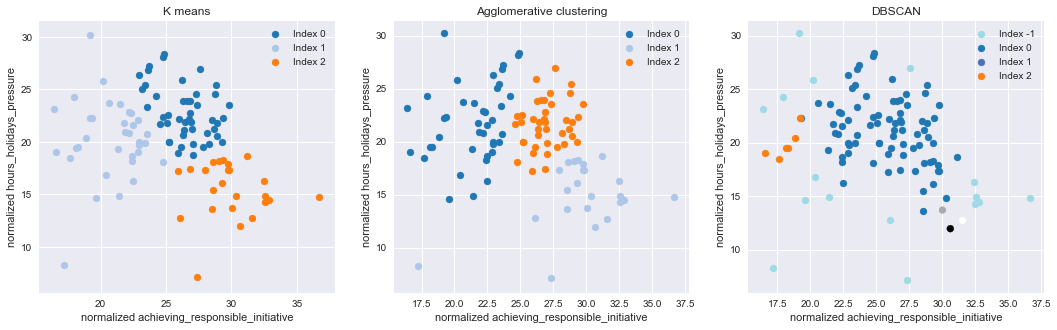

In [111]:
# Plot countries, using different clustering algorithms and variables
plotter(df = country_averages, 
        input_cols = ['normalized achieving_responsible_initiative', 'normalized hours_holidays_pressure'],
        k_means_n_clusters = 3, agglom_n_clusters = 3, dbscan_eps = 2)

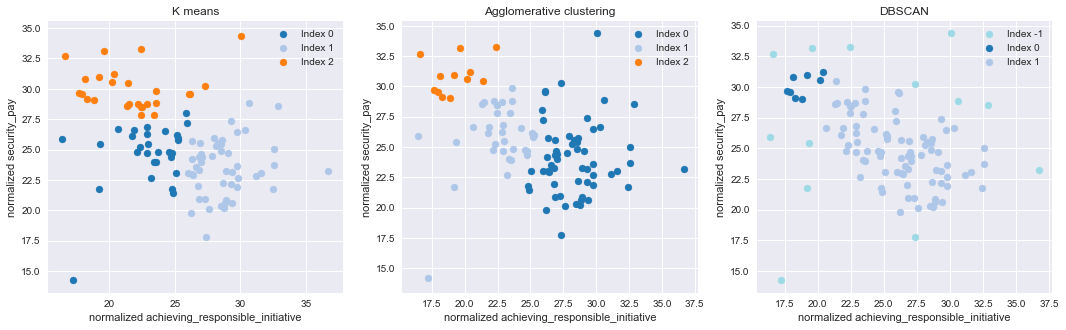

In [112]:
plotter(df = country_averages, 
        input_cols = ['normalized achieving_responsible_initiative', 'normalized security_pay'],
        k_means_n_clusters = 3, agglom_n_clusters = 3, dbscan_eps = 2)

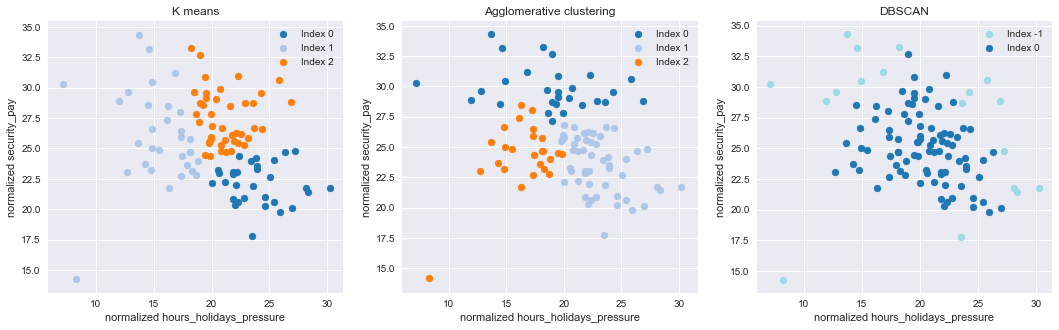

In [113]:
plotter(df = country_averages, 
        input_cols = ['normalized hours_holidays_pressure', 'normalized security_pay'],
        k_means_n_clusters = 3, agglom_n_clusters = 3, dbscan_eps = 2)

#### The top left chart (kmeans clustering with the two axes as achieving/ responsible/ initiative and hours/ holidays/ pressure accounts) provides the best visual separation. Proceeding with this...

In [124]:
# Modify our plotter to focus on k-means and add point labels

def k_means_plotter(df, input_cols, k_means_n_clusters = 3, n_rows = 1, n_cols = 1, _cmap = plt.get_cmap('tab20')):
    '''function to visualize kmean clustering
    args: dataframe, input_cols --> to pull in from df, agglom_n_clusters, dbscan_eps, dbscan_min_samples
    kwargs: k_means_n_clusters = 3, n_rows = 1, n_cols =1 --> rows/ cols of subplots, _cmap = plt.get_cmap('tab20')'''
    # pull out columns to plot and scale
    cols_to_plot = df[input_cols]
    figure, ax = plt.subplots(nrows = n_rows, ncols=n_cols, figsize=(18,10))
    # k means
    kmeans = KMeans(n_clusters=k_means_n_clusters)
    kmeans.fit(cols_to_plot)
    df['kmeans_labels'] = kmeans.labels_
    for index, sub_dataframe in df.groupby('kmeans_labels'):
        ax.set_title("K means")
        ax.scatter(sub_dataframe[input_cols[0]], sub_dataframe[input_cols[1]], c=_cmap.colors[index], label = f"Index {index}")
        ax.set_xlabel(input_cols[0])
        ax.set_ylabel(input_cols[1])
        ax.legend()

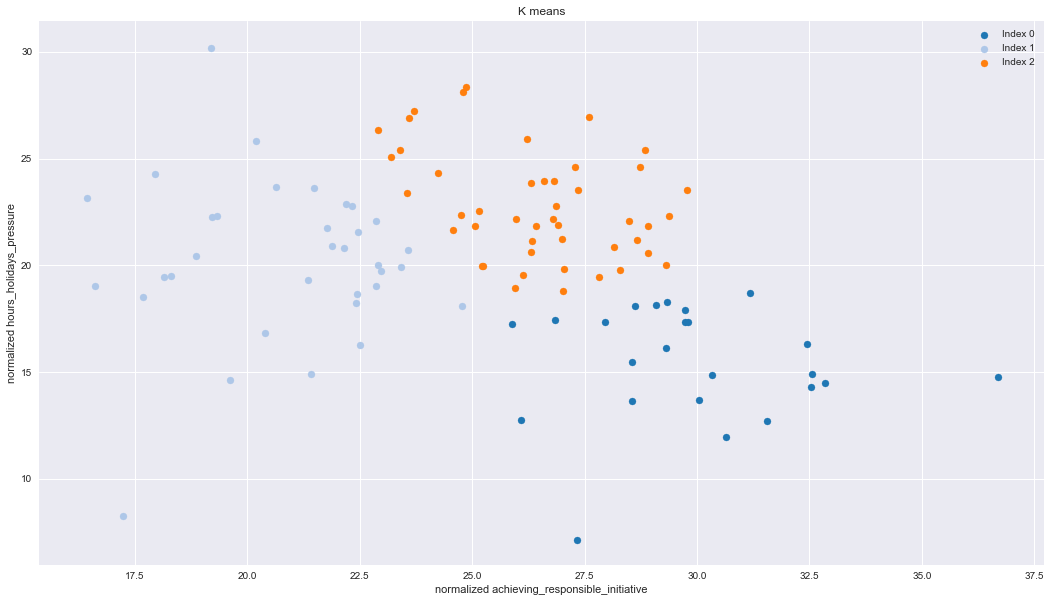

In [125]:
k_means_plotter(df = country_averages, 
        input_cols = ['normalized achieving_responsible_initiative', 'normalized hours_holidays_pressure'])